# Bayesian regression, four ways

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Univariate normal distribution
Let's try to infer the most likely parameters of a normal distribution given some data ($y$).
We'll generate some data (of size $N = 100$) with known parameters $\mu = 0$ and $\sigma = 1$:

\begin{align}
y \sim N(0, 1)
\end{align}

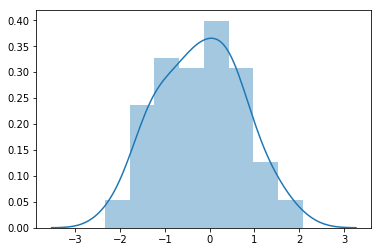

In [2]:
N = 100
y = np.random.normal(0, 1, size=N)

sns.distplot(y)

Now, the analytical (estimated) mean is calculated as:

\begin{align}
\bar{y} = \frac{1}{N}\sum_{i}^{N}y_{i} 
\end{align}

And the analytical standard deviation is calculated as:

\begin{align}
s = \frac{1}{N}\sum_{i}^{N}(y_{i} - \bar{y})^2
\end{align}

Let's do just that:

In [3]:
y_est_mean = np.mean(y)
y_est_sd = np.std(y)

print('Estimated mean: %.3f' % y_est_mean)
print('Estimated sd: %.3f' % y_est_sd)

Estimated mean: -0.202
Estimated sd: 0.935


Now, how about a bayesian estimation?

\begin{align}
p(\theta \mid y) \propto p(y \mid \theta)p(\theta)
\end{align}

Let's use completely flat priors to mimic the analytical solution:

In [4]:
model = pm.Model()

with model:
    
    mu = pm.Flat('mu')
    sigma = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
    trace_ndist = pm.sample(steps=10000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 2168.40draws/s]
The acceptance probability does not match the target. It is 0.890584688279009, but should be close to 0.8. Try to increase the number of tuning steps.


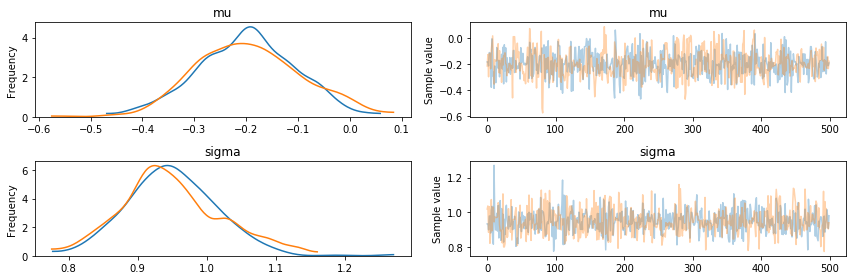

Estimated mean, bayesian: -0.199
Estimated sd, bayesian: 0.949


In [5]:
pm.traceplot(trace_ndist)
plt.show()

y_est_mean_bayes = np.mean(trace_ndist['mu'])
y_est_sd_bayes = np.mean(trace_ndist['sigma'])

print('Estimated mean, bayesian: %.3f' % y_est_mean_bayes)
print('Estimated sd, bayesian: %.3f' % y_est_sd_bayes)

Close enough!

## OLS regression
Now, let's also generate some independent variable, $X$, which we'll use to re-generate our $y$ variable:

\begin{align}
y = X\beta + \epsilon \sim N(0, 1)
\end{align}

In [27]:
X = np.random.normal(0, 1, size=N)
X = np.c_[np.ones(N), X]
epsilon = np.random.normal(0, 2, size=N)
betas = np.array([1, 2])
y = X.dot(betas) + epsilon

Now, let's first estimate the parameters ($\beta$) using the analytical version (OLS):

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

In [44]:
betas_ols = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
sigmasq_ols = np.sum((y - X.dot(betas_ols)) ** 2) / (N - 2)
covar_betas_ols = sigmasq_ols * np.linalg.inv(X.T.dot(X))
print('Estimated params, OLS: %s' % (betas_ols,))
print('Estimated sigma, OLS: %s' % (sigmasq_ols,))

covar_betas_ols

Estimated params, OLS: [1.08692443 2.1164952 ]
Estimated sigma, OLS: 4.243954441243169


array([[ 0.0426188 , -0.00317906],
       [-0.00317906,  0.05637914]])

And the Bayesian way:

\begin{align}
y \sim N(X\beta, \sigma I)
\end{align}

In [45]:
ols_model = pm.Model()

with ols_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas_bayes), sd=sigma_bayes, observed=y)
    trace_ols = pm.sample(10000, cores=2)
    map_est = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:08<00:00, 2433.00draws/s]
logp = -226.99, ||grad|| = 0.76928: 100%|██████████| 25/25 [00:00<00:00, 1891.20it/s]         


In [46]:
betas_est_bayes = np.mean(trace_ols['betas'], axis=0)
sd_est_bayes = np.mean(trace_ols['sigma'])
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))

Estimated params, bayes: [1.0855259  2.11664777]
Estimated sd, bayes: 2.087115271335256


Note that the (co)variance of the posterior distributions of the parameters ($\beta$) is the same as the analytical (OLS) solution when assuming a flat prior over the parameters. 

In [50]:
np.cov(trace_ols['betas'].T)

array([[ 0.04421924, -0.00326133],
       [-0.00326133,  0.05828122]])

Also, it's actually quite easy to run a (bayesian) GLM with OLS-like likelihoods (Gaussian) and priors (flat) using the `glm` module of pymc3:

In [62]:
data = pd.DataFrame({'X1': X[:, 1], 'y': y})
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ X1', data=data,
                            family='normal',
                            priors=None)
    
    trace = pm.sample(2000, cores=2)

print(np.mean(trace['Intercept'], axis=0))
print(np.mean(trace['X1'], axis=0))
print(np.mean(trace['sd'], axis=0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, X1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:01<00:00, 2646.79draws/s]


1.0879001092493472
2.107012108512379
2.0853705635268884


Same same!

## Ridge
To be continued!

In [196]:
np.sqrt(lambd**-2)

0.2

In [214]:
lambds = [0.1, 0.5, 1, 5, 10, 100]

b_ridge = np.zeros(6)
b_ridge_b = np.zeros(6)
for i, lambd in enumerate(lambds):
    b_ridge[i] = np.linalg.inv(X.T.dot(X) + lambd**2*np.eye(2)).dot(X.T).dot(y)[1]
    
    ridge_model = pm.Model()

    with ridge_model:
        betas = pm.Normal('betas', 0, sd=lambd**-2, shape=2)
        sigma = pm.Uniform('sigma', lower=0, upper=10**6)
        y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sd=sigma, observed=y)
        b_ridge_b[i] = pm.find_MAP()['betas'][1]
        
#print("Betas, ridge: %s" % (betas_ridge,))

logp = -238.03, ||grad|| = 0.76914: 100%|██████████| 25/25 [00:00<00:00, 1625.17it/s]         
logp = -231.77, ||grad|| = 0.68486: 100%|██████████| 25/25 [00:00<00:00, 2150.53it/s]         
logp = -231.51, ||grad|| = 0.37674: 100%|██████████| 25/25 [00:00<00:00, 1957.39it/s]         
logp = -260.48, ||grad|| = 6.6351e-05: 100%|██████████| 22/22 [00:00<00:00, 2032.35it/s]      
logp = -258.1, ||grad|| = 0.098462: 100%|██████████| 23/23 [00:00<00:00, 1607.04it/s]         
logp = -256.89, ||grad|| = 335.87: 100%|██████████| 30/30 [00:00<00:00, 2129.92it/s]          


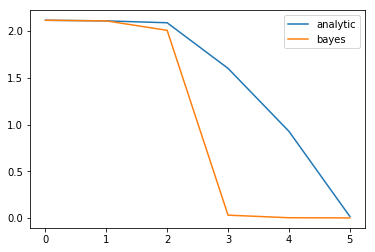

In [215]:
plt.plot(b_ridge)
plt.plot(b_ridge_b)
plt.legend(['analytic', 'bayes'])

In [172]:
ridge_model = pm.Model()

with ridge_model:
    betas = pm.Normal('betas', 0, sd=lambd**-1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sd=sigma, observed=y)
    trace_ridge = pm.sample(5000, cores=2)
    map_ridge = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 1905.69draws/s]
The acceptance probability does not match the target. It is 0.8897299615887581, but should be close to 0.8. Try to increase the number of tuning steps.
logp = -254.07, ||grad|| = 0.00040987: 100%|██████████| 23/23 [00:00<00:00, 2043.14it/s]      


[0.45018924 0.69747601]
[1.04204898 1.98832762]


{'betas': array([0.46004404, 0.71393943]),
 'sigma_interval__': array(-12.9082382),
 'sigma': array(2.47754928)}

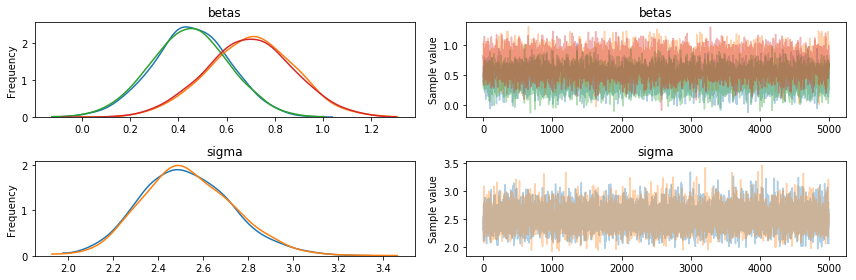

In [174]:
pm.traceplot(trace_ridge)
print(np.mean(trace_ridge['betas'], axis=0))
print(betas_ridge)
map_ridge